### Prelude:
We load frames and explore them a little bit <br>
We need to see what are they containing

In [171]:
import pandas as pd
frame = pd.read_csv('./data/headgear.csv')
frame.head()

,class id,filepaths,labels,data set
0,0,train/ASCOT CAP/001.jpg,ASCOT CAP,train
1,0,train/ASCOT CAP/002.jpg,ASCOT CAP,train
2,0,train/ASCOT CAP/003.jpg,ASCOT CAP,train
3,0,train/ASCOT CAP/004.jpg,ASCOT CAP,train
4,0,train/ASCOT CAP/005.jpg,ASCOT CAP,train


In [172]:
# create a mapping between 'class id' and 'labels' columns
id_to_label = dict(zip(frame['class id'], frame['labels']))
id_to_label

{0: 'ASCOT CAP',
 1: 'BASEBALL CAP',
 2: 'BERET',
 3: 'BICORNE',
 4: 'BOATER',
 5: 'BOWLER',
 6: 'DEERSTALKER',
 7: 'FEDORA',
 8: 'FEZ',
 9: 'FOOTBALL HELMET',
 10: 'GARRISON CAP',
 11: 'HARD HAT',
 12: 'MILITARY HELMET',
 13: 'MOTARBOARD',
 14: 'PITH HELMET',
 15: 'PORK PIE',
 16: 'SOMBERO',
 17: 'SOUTHWESTER',
 18: 'TOP HAT',
 19: 'ZUCCHETTO'}

In [173]:
data = frame.drop(['labels'], axis=1)

def get_data_set(dataset: str) -> pd.DataFrame:
  global data
  filtered = data[data['data set'] == dataset]
  return filtered.drop(['data set'], axis=1)

train_frame = get_data_set('train')
test_frame  = get_data_set('test')
valid_frame = get_data_set('valid')

In [174]:
train_frame.head()

,class id,filepaths
0,0,train/ASCOT CAP/001.jpg
1,0,train/ASCOT CAP/002.jpg
2,0,train/ASCOT CAP/003.jpg
3,0,train/ASCOT CAP/004.jpg
4,0,train/ASCOT CAP/005.jpg


### Making DataSets
To later feed data into our neural network, it's important to create datasets <br>
There will be different datasets for training, testing and validation <br>
It's also important to think how we gonna transform our data

In [175]:
from torch.utils.data import Dataset
from PIL import Image

class HeadgearDataset(Dataset):
  def __init__(self, frame: pd.DataFrame, transform=None) -> None:
    self.frame = frame
    self.transform = transform

  def __len__(self) -> int:
    return len(self.frame)

  def __getitem__(self, idx: int) -> tuple:
    row = self.frame.iloc[idx]
    relative_path = row['filepaths']
    absolute_path = './data/' + relative_path
    image = Image.open(absolute_path)
    label = row['class id']
    if self.transform:
      image = self.transform(image)
    return image, label

### Below is my previous attempt to transform the data.
Things that I've done:
1. Data augmentation: randomly rotating image, shifting, flipping
2. grayscale image and turn it into values between 0 and 1

In [176]:
import torch
import numpy as np

def image_to_tensor(image: Image) -> torch.Tensor:
  image = image.convert('L')
  array = torch.from_numpy(np.array(image))
  array = array / 255.0
  return array.unsqueeze(0)

def data_augmentation(image: Image) -> Image:
  # randomly rotate the image
  angle = np.random.randint(0, 360)
  image =  image.rotate(angle)
  # randomly flip the image
  if np.random.rand() > 0.5:
    image = image.transpose(Image.FLIP_LEFT_RIGHT)
  # randomly shift the image
  shift = np.random.randint(-10, 10)
  image = image.transform(image.size, Image.AFFINE, (1, 0, shift, 0, 1, 0))
  return image

def transformer(image: Image) -> torch.Tensor:
  image = data_augmentation(image)
  return image_to_tensor(image)

train_dataset = HeadgearDataset(train_frame, transform=transformer)
test_dataset  = HeadgearDataset(test_frame, transform=image_to_tensor)
valid_dataset = HeadgearDataset(valid_frame, transform=image_to_tensor)

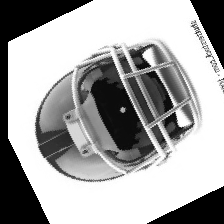

In [177]:
import random
index = random.randint(0, len(train_dataset))
_, image = train_frame.iloc[index]
image = Image.open('./data/' + image)
image = image.convert('L')
data_augmentation(image)

In [178]:
images, _ = train_dataset[0]
images.shape

torch.Size([1, 224, 224])

### Now I am using a simpler approach
1. I will use all 3 colors on my images to correctly determine where is the hat
2. I won't use data augmentation (maybe later)
3. In case of data augmentation I can use changing colors

In [179]:
import numpy as np
import torch
from PIL import Image, ImageEnhance

def image_to_tensor(image: Image) -> torch.Tensor:
  image = image.convert('RGB')
  array = np.array(image)
  array = array / 255.0
  array = array.transpose(2, 0, 1)
  return torch.from_numpy(array).float()

def data_augmentation(image: Image, rotate: bool = False) -> Image:
  if np.random.rand() > 0.5: 
    return image
  # change the brightness
  brightness = np.random.uniform(0.5, 1.5)
  image = ImageEnhance.Brightness(image).enhance(brightness)
  # change the contrast
  contrast = np.random.uniform(0.5, 1.5)
  image = ImageEnhance.Contrast(image).enhance(contrast)
  # change the saturation
  saturation = np.random.uniform(0.5, 1.5)
  image = ImageEnhance.Color(image).enhance(saturation)
  # change the hue
  hue = np.random.uniform(-0.1, 0.1)
  image = np.array(image.convert('HSV'))
  image[:, :, 0] = image[:, :, 0] + hue * 255
  image = Image.fromarray(image, mode='HSV').convert('RGB')

  if not rotate:
    return image
  
  # randomly flip the image
  if np.random.rand() > 0.5:
    image = image.transpose(Image.FLIP_LEFT_RIGHT)
  # randomly rotate the image
  angle = np.random.randint(0, 360)
  image = image.rotate(angle)
  return image

def augmentation_transformer(image: Image) -> torch.Tensor:
  image = data_augmentation(image, rotate=False)
  return image_to_tensor(image)

train_dataset = HeadgearDataset(train_frame, transform=augmentation_transformer)
test_dataset  = HeadgearDataset(test_frame,  transform=image_to_tensor)
valid_dataset = HeadgearDataset(valid_frame, transform=image_to_tensor)

In [180]:
first_image = train_dataset[0][0]
print(first_image.shape)
print(first_image.type())

torch.Size([3, 224, 224])
torch.FloatTensor


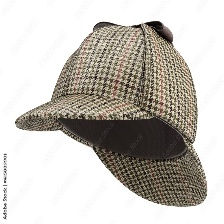

In [181]:
random_image = Image.open('./data/' + train_frame.iloc[1000]['filepaths'])
data_augmentation(random_image)

### Building the neural network:
We define some helping modules like ConvUnit and DenseUnit to use them later. <br>
After that, we build our network using extraction base containing ConvUnits and classification head containing DenseUnits

In [182]:
from torch import nn

class ConvUnit(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, conv_kernel: int = 3, pool_kernel: int = 2, normalization: bool = True) -> None:
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=conv_kernel, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.normalize = normalization
    if normalization:
      self.batch_norm = nn.BatchNorm2d(out_channels)
    self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_kernel)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv(x)
    x = self.relu(x)
    if self.normalize:
      x = self.batch_norm(x)
    x = self.pool(x)
    return x

class DenseUnit(nn.Module):
  def __init__(self, in_features: int, out_features: int, dropout: int = 0, normalization: bool = True) -> None:
    super().__init__()
    self.linear = nn.Linear(in_features, out_features)
    self.relu = nn.ReLU()
    self.normalize = normalization
    if normalization:
      self.batch_norm = nn.BatchNorm1d(out_features)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.linear(x)
    x = self.relu(x)
    if self.normalize:
      x = self.batch_norm(x)
    x = self.dropout(x)
    return x


In [183]:
from torch import nn

class HeadgearRecognizer(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.extractor = nn.Sequential(
      ConvUnit(3, 32, conv_kernel=5, pool_kernel=3),
      ConvUnit(32, 64),
      ConvUnit(64, 128),
      ConvUnit(128, 256),
    )
    self.flatten = nn.Flatten()
    self.classifier = nn.Sequential(
      DenseUnit(20736, 1024),
      DenseUnit(1024, 512, dropout=0.25),
      DenseUnit(512, 512),
      DenseUnit(512, 256, dropout=0.25),
      DenseUnit(256, 20, normalization=False),
    )
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.extractor(x)
    x = self.flatten(x)
    x = self.classifier(x)
    return self.softmax(x)


### Instantiation, training, evaluation
1. We create an instance of our network
2. We create loaders
3. Using a supervisor class, we train, evaluate and save our model

In [184]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [185]:
def recognize_device(debug: bool = False) -> str:
  if debug:
    return 'cpu'
  if torch.cuda.is_available():
    return 'cuda'
  if torch.backends.mps.is_available():
    return 'mps'
  return 'cpu'

In [186]:
mode = input('Using debug mode? (y/N): ').lower()
debug = mode == 'y'
device = recognize_device(debug)
model = HeadgearRecognizer().to(device)
device

'mps'

### Supervisor class
Very huge class responsible for training, statistics, plotting, evaluating, saving, etc...

In [187]:
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader

History = list[list[float]]

class Supervisor:
  def __init__(self, model: nn.Module, learning_rate: float = 0.001) -> None:
    self.model = model
    self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    self.loss_function = nn.CrossEntropyLoss()
    self.train_history = []
  
  @property
  def history(self) -> History:
    return self.train_history
  
  def train_model(self, train_loader: DataLoader, valid_loader: DataLoader | None = None, epochs: int = 10, debug: bool = True) -> History:
    # variables that will be used in statistics
    total_loss, total_correct = 0, 0
    tries = 0

    for epoch in range(epochs):
      # setting model to train mode for the whole epoch
      model.train()
      for images, labels in train_loader:
        # training
        images, labels = images.to(device), labels.to(device)
        self.optimizer.zero_grad()
        output = self.model(images)
        loss = self.loss_function(output, labels)
        loss.backward()
        self.optimizer.step()

        # statistics
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_correct += (predicted == labels).sum().item()
        tries += labels.size(0)
      
      avg_loss = total_loss / tries
      avg_acc = total_correct / tries

      # making a history dump
      history_dump = [avg_loss, avg_acc]
      if valid_loader is not None:
        valid_loss, valid_acc = self.evaluate_model(valid_loader, debug=False)
        history_dump.extend([valid_loss, valid_acc])
      self.train_history.append(history_dump)

      # printing debug message
      if debug:
        debug_message = f'Epoch {epoch + 1}, loss: {avg_loss:.4f}, accuracy: {avg_acc:.4f}'
        if valid_loader is not None:
          debug_message += f', validation loss: {valid_loss:.4f}, validation accuracy: {valid_acc:.4f}'
        print(debug_message)
      
      total_loss, total_correct, tries = 0, 0, 0
    return self.train_history
  
  def evaluate_model(self, test_loader: DataLoader, debug: bool = True) -> tuple[float, float]:
    self.model.eval()
    total_loss, total_correct = 0, 0
    tries = 0
    with torch.no_grad():
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = self.model(images)
        loss = self.loss_function(output, labels)
        # statistics
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_correct += (predicted == labels).sum().item()
        tries += labels.size(0)
    avg_loss = total_loss / tries
    avg_acc = total_correct / tries
    if debug:
      print(f'Evaluation, loss: {avg_loss:.4f}, accuracy: {avg_acc:.4f}')
    return avg_loss, avg_acc
  
  def save_model(self, name: str) -> None:
    torch.save(self.model, f'./models/{name}.pth')
    torch.save(self.model.state_dict(), f'./models/{name}.state')
  
  def plot_statistics(self) -> None:
    # if validation history is empty, extend it with train history
    history = list(map(lambda e: e + e if len(e) == 2 else e, self.train_history))
    history = np.array(history)
    # plot every metric in a separate subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Training statistics')
    ax1.plot(history[:, 0], label='Train loss')
    ax1.plot(history[:, 2], label='Validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(history[:, 1], label='Train accuracy')
    ax2.plot(history[:, 3], label='Validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()


### Here I train and experiment with model

In [188]:
supervisor = Supervisor(model, learning_rate=0.001)

In [193]:
history = supervisor.train_model(train_loader, valid_loader=valid_loader, epochs=10)

Epoch 1, loss: 0.0392, accuracy: 0.5903, validation loss: 0.0499, validation accuracy: 0.5800
Epoch 2, loss: 0.0402, accuracy: 0.5271, validation loss: 0.0525, validation accuracy: 0.4500
Epoch 3, loss: 0.0404, accuracy: 0.5113, validation loss: 0.0511, validation accuracy: 0.5300
Epoch 4, loss: 0.0393, accuracy: 0.5796, validation loss: 0.0510, validation accuracy: 0.5200
Epoch 5, loss: 0.0389, accuracy: 0.6088, validation loss: 0.0499, validation accuracy: 0.5800
Epoch 6, loss: 0.0386, accuracy: 0.6246, validation loss: 0.0494, validation accuracy: 0.6000
Epoch 7, loss: 0.0386, accuracy: 0.6273, validation loss: 0.0503, validation accuracy: 0.5600
Epoch 8, loss: 0.0384, accuracy: 0.6448, validation loss: 0.0501, validation accuracy: 0.5700
Epoch 9, loss: 0.0382, accuracy: 0.6544, validation loss: 0.0503, validation accuracy: 0.5600
Epoch 10, loss: 0.0380, accuracy: 0.6699, validation loss: 0.0492, validation accuracy: 0.6000


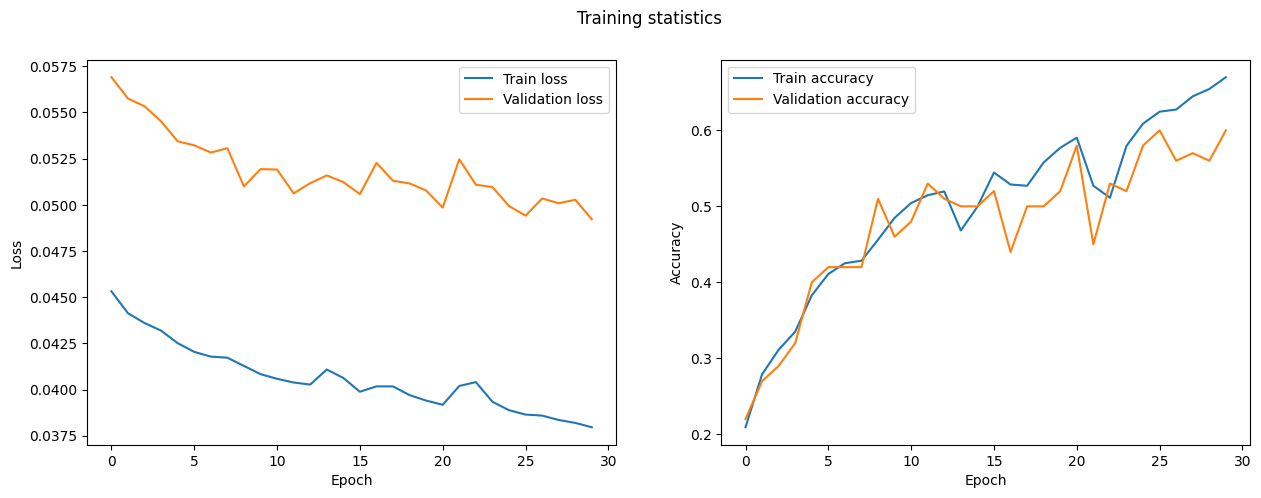

In [194]:
supervisor.plot_statistics()

In [196]:
supervisor.evaluate_model(test_loader)

Evaluation, loss: 0.0493, accuracy: 0.6000


(0.04925888776779175, 0.6)

In [197]:
_, accuracy = supervisor.evaluate_model(test_loader, debug=False)
name = f'model-{accuracy:.4f}'
supervisor.save_model(name)
f'Saved model as {name}'

'Saved model as model-0.6000'